# Проект: Выбор локации для скважины


## Описание проекта

Для добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.
Компанией редоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

**Цель**

1. Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. 
2. Проанализировать возможную прибыль и риски техникой Bootstrap.

**Шаги для выбора локации**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Описание данных**

Данные геологоразведки трёх регионов находятся в файлах: 
- /datasets/geo_data_0.csv.
- /datasets/geo_data_1.csv. 
- /datasets/geo_data_2.csv. 

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

**Условия задачи**

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

**Этапы выполнения задачи**

1. Загрузка и подготовка данных
2. Обучение и проверька модели для каждого региона
3. Подготовка к расчёту прибыли
4. Написание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели
5. Посчет рисков и прибыли для каждого региона:
6. Выводы

## 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

RANDOM_STATE = 100
test_size = 0.25

pd.options.display.float_format = '{:,.2f}'.format

Загрузим датасеты, создадим функцию для получения общей информации, наличия пропусков, явных дубликатов, построения диаграмм и матрицы корреляции.

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
def check_df(df):    
    display(df.info())   
    display(df.head())
    display(df.describe())
    display(df.isna().sum())   
    display(df.duplicated().sum())
    
    
def hist_box_plot(df, column):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df[column], color='Green', kde=True, bins=25)
    plt.title(f'Гистограмма {column}')
    plt.xlabel(f'{column}')
    plt.ylabel('Количество скважин')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[column], color='Red')
    plt.title(f'Диаграмма рассеяния {column}')
    plt.ylabel('Количество скважин')
    
    
def corr_matrix(df):    
    corr_matrix = df.corr()
    display(corr_matrix)
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm");
    plt.show()
 

### 1.1 Исследование датасета geo_data_0

In [4]:
check_df(geo_data_0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.72,128.56
max,2.36,1.34,16.00,185.36


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

0

Пропусков нет, тип данных соответствует, названия столбцов не требует изменения регистра, явных дубликатов нет. Сделаем столбец id индексом.

In [5]:
geo_data_0 = geo_data_0.set_index('id')
geo_data_0.head()

,f0,f1,f2,product
id,,,,
txEyH,0.71,-0.50,1.22,105.28
2acmU,1.33,-0.34,4.37,73.04
409Wp,1.02,0.15,1.42,85.27
iJLyR,-0.03,0.14,2.98,168.62
Xdl7t,1.99,0.16,4.75,154.04


Построим гистограммы и диаграммы рассеяния датасета.

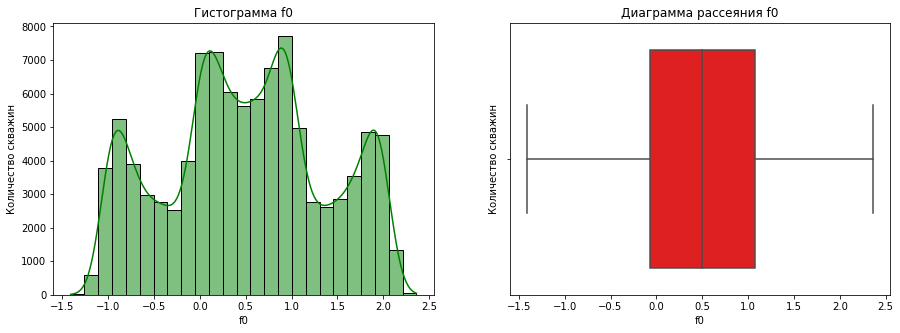

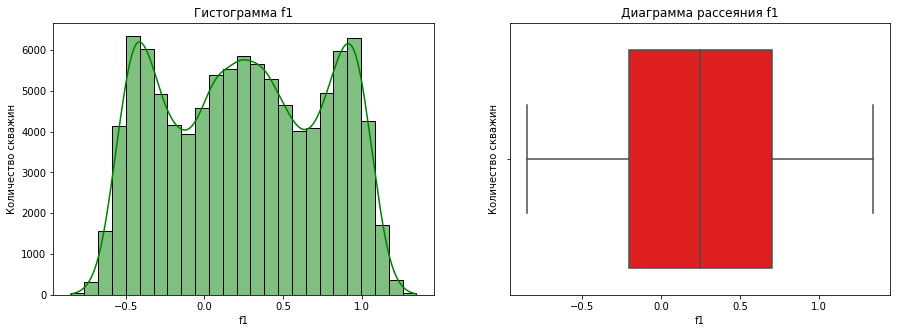

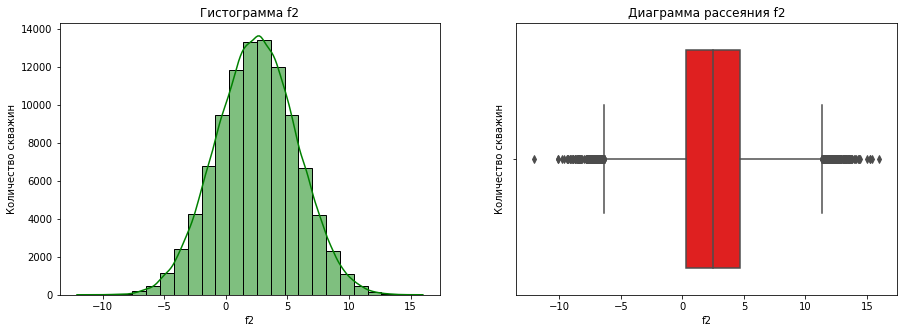

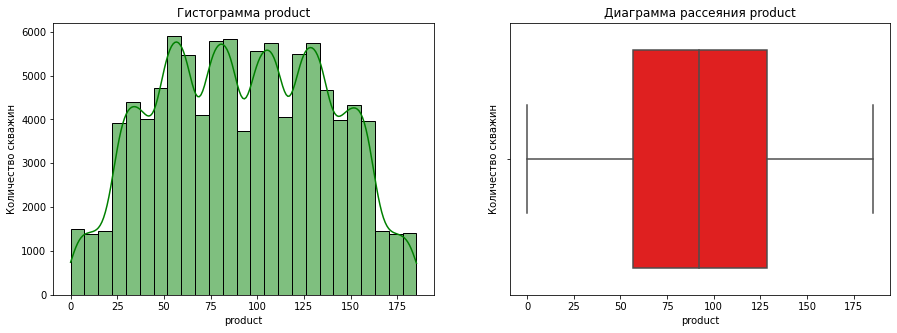

In [6]:
for column in geo_data_0:
    hist_box_plot(geo_data_0, column)

Наблюдаются выбросы в признаке f2, удалять не будем. Построим матрицу корреляции.

,f0,f1,f2,product
f0,1.00,-0.44,-0.00,0.14
f1,-0.44,1.00,0.00,-0.19
f2,-0.00,0.00,1.00,0.48
product,0.14,-0.19,0.48,1.00


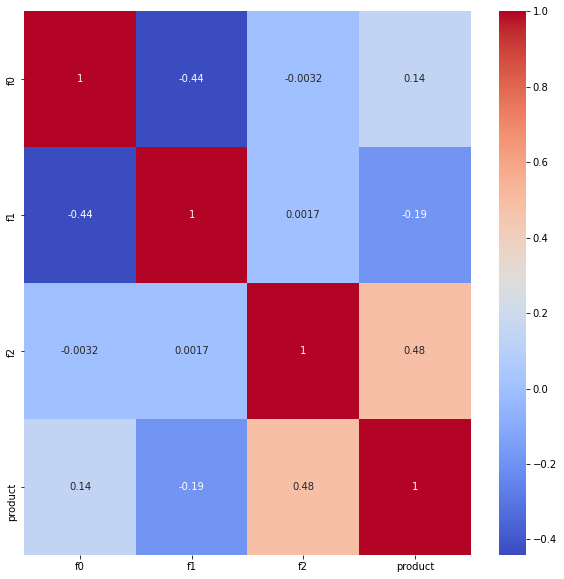

In [7]:
corr_matrix(geo_data_0)

Корреляционный анализ показывает совсем слабую зависимость между признаками f2 и product.

### 1.2 Исследование датасета geo_data_1

In [8]:
check_df(geo_data_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,1.14,-4.80,2.49,68.83
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

0

Пропусков нет, тип данных соответствует, названия столбцов не требует изменения регистра, явных дубликатов нет. Сделаем столбец id индексом.

In [9]:
geo_data_1 = geo_data_1.set_index('id')
geo_data_1.head()

,f0,f1,f2,product
id,,,,
kBEdx,-15.00,-8.28,-0.01,3.18
62mP7,14.27,-3.48,1.00,26.95
vyE1P,6.26,-5.95,5.00,134.77
KcrkZ,-13.08,-11.51,5.00,137.95
AHL4O,12.70,-8.15,5.00,134.77


Построим гистограммы и диаграммы рассеяния датасета.

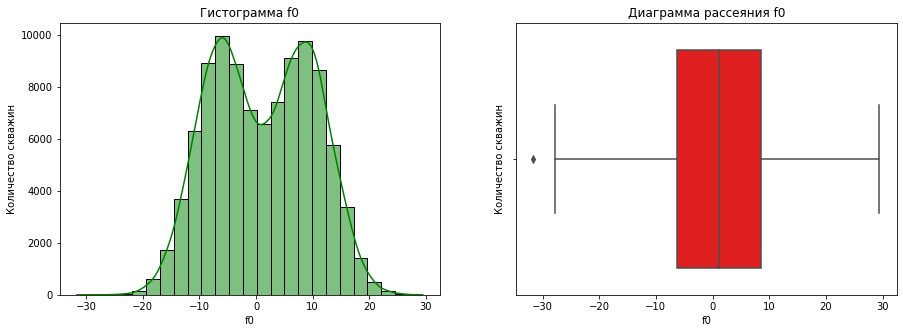

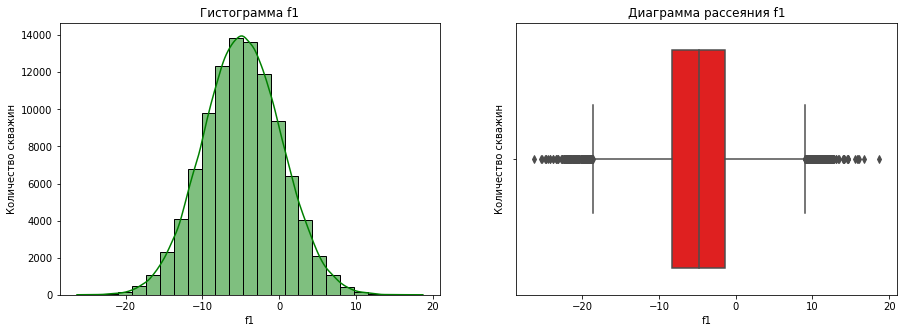

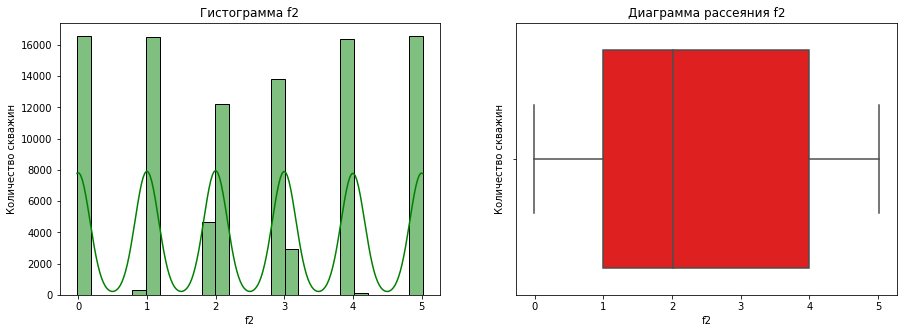

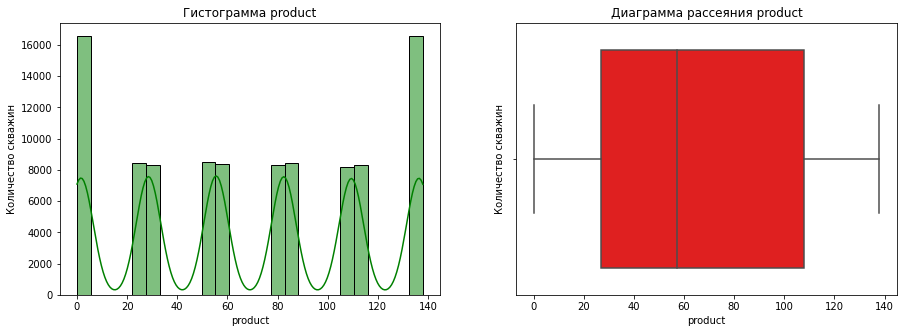

In [10]:
for column in geo_data_1:
    hist_box_plot(geo_data_1, column)

Наблюдаются выбросы в признаке f1 и один выброс в признаке f0. Построим матрицу корреляции.

,f0,f1,f2,product
f0,1.00,0.18,-0.00,-0.03
f1,0.18,1.00,-0.00,-0.01
f2,-0.00,-0.00,1.00,1.00
product,-0.03,-0.01,1.00,1.00


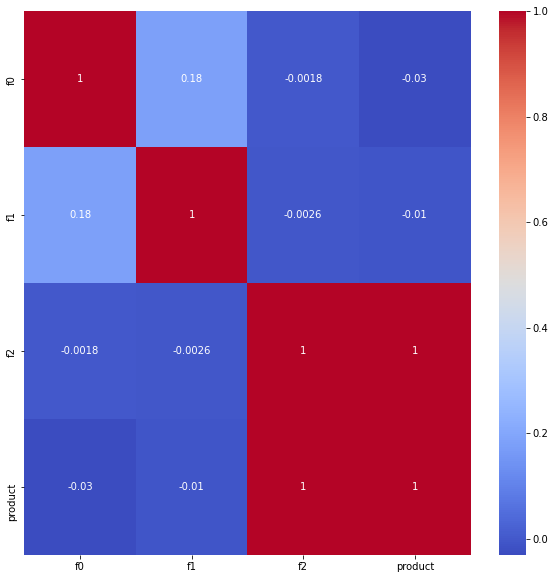

In [11]:
corr_matrix(geo_data_1)

Корреляционный анализ показывает сильную зависимость между признаками f2 и product.

### 1.3 Исследование датасета geo_data_2

In [12]:
check_df(geo_data_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


,f0,f1,f2,product
count,"100,000.00","100,000.00","100,000.00","100,000.00"
mean,0.00,-0.00,2.50,95.00
std,1.73,1.73,3.47,44.75
min,-8.76,-7.08,-11.97,0.00
25%,-1.16,-1.17,0.13,59.45
50%,0.01,-0.01,2.48,94.93
75%,1.16,1.16,4.86,130.60
max,7.24,7.84,16.74,190.03


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

0

Пропусков нет, тип данных соответствует, названия столбцов не требует изменения регистра, явных дубликатов нет. Сделаем столбец id индексом.

In [13]:
geo_data_2 = geo_data_2.set_index('id')
geo_data_2.head()

,f0,f1,f2,product
id,,,,
fwXo0,-1.15,0.96,-0.83,27.76
WJtFt,0.26,0.27,-2.53,56.07
ovLUW,0.19,0.29,-5.59,62.87
q6cA6,2.24,-0.55,0.93,114.57
WPMUX,-0.52,1.72,5.90,149.60


Построим гистограммы и диаграммы рассеяния датасета.

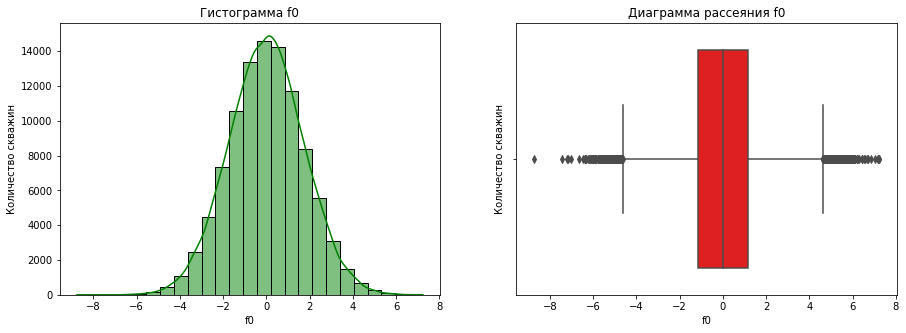

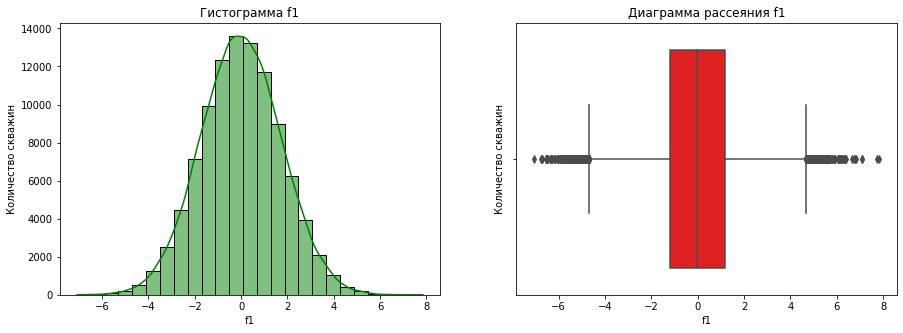

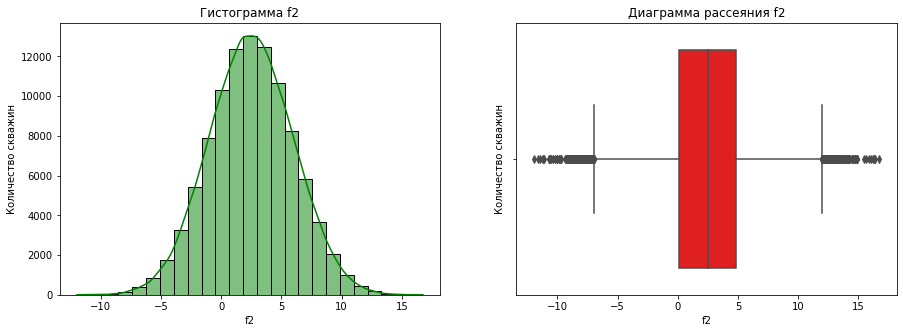

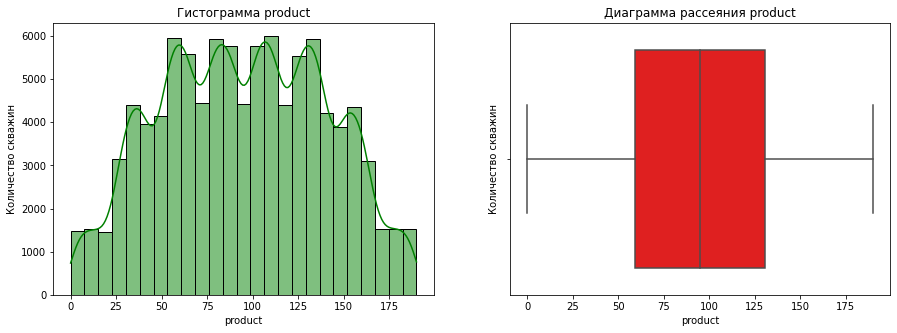

In [14]:
for column in geo_data_2:
    hist_box_plot(geo_data_2, column)

Наблюдаются выбросы в признаках f0, f1, f2. Построим матрицу корреляции.

,f0,f1,f2,product
f0,1.00,0.00,-0.00,-0.00
f1,0.00,1.00,0.00,-0.00
f2,-0.00,0.00,1.00,0.45
product,-0.00,-0.00,0.45,1.00


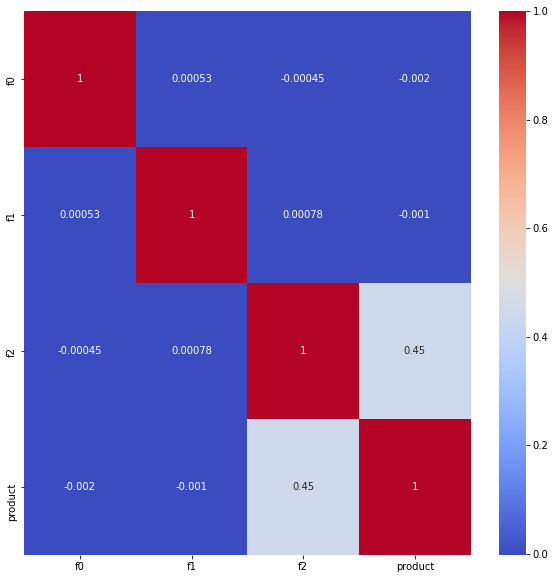

In [15]:
corr_matrix(geo_data_2)

Корреляционный анализ показывает совсем слабую зависимость между признаками f2 и product.

## 2. Обучение и проверка модели


Разобъем данные на обучающую и валидационную выборки в соотношении 75:25, используя функцию.

In [16]:
def data_preprocessing(df):
    X = df.drop('product', axis=1)
    y = df['product']
        
    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        y,
        test_size=0.25,
        random_state=RANDOM_STATE)
    
    return X_train, X_valid, y_train, y_valid

In [17]:
X_train_0, X_valid_0, y_train_0, y_valid_0 = data_preprocessing(geo_data_0)
X_train_1, X_valid_1, y_train_1, y_valid_1 = data_preprocessing(geo_data_1)
X_train_2, X_valid_2, y_train_2, y_valid_2 = data_preprocessing(geo_data_2)

Обучим модель и сделаем предсказания на валидационной выборке.

In [18]:
def learning_process(X_train, X_valid, y_train, y_valid, names):
    model = make_pipeline(StandardScaler(), LinearRegression())
    
    model.fit(X_train, y_train)
    predicted_valid = model.predict(X_valid)
    
    mse = mean_squared_error(y_valid, predicted_valid)
       
    print(f'Средний запас предсказанного сырья для {names} региона: {predicted_valid.mean():.3f} тыс.баррелей')
    print(f'RMSE модели: {mse**0.5:.3f}')
    print()
    
    return predicted_valid    

Передадим созданной функции датасеты . Выведем на экран средний запас предсказанного сырья и RMSE модели.

In [19]:
predicted_valid_0 = learning_process(X_train_0, X_valid_0, y_train_0, y_valid_0, 'geo_data_0')
predicted_valid_1 = learning_process(X_train_1, X_valid_1, y_train_1, y_valid_1, 'geo_data_1')
predicted_valid_2 = learning_process(X_train_2, X_valid_2, y_train_2, y_valid_2, 'geo_data_2')

Средний запас предсказанного сырья для geo_data_0 региона: 92.364 тыс.баррелей
RMSE модели: 37.703

Средний запас предсказанного сырья для geo_data_1 региона: 68.772 тыс.баррелей
RMSE модели: 0.890

Средний запас предсказанного сырья для geo_data_2 региона: 94.912 тыс.баррелей
RMSE модели: 40.109



**Вывод:** в третьем регионе средний запас предсказанного сырья оказался больше первых двух , равен 94,912 тыс.баррелей. При этом RMSE(вадратный корень из среднеквадратичной ошибки) модели второго региона, равный 0,890, сильно отличается от первого и третьго региона. Это говорит о том, что в первом и третьем регионе большой разброс данных целевого признака, и предсказанные значения не имеют высокой точности. 

## 3. Подготовка к расчёту прибыли

Все ключевые значения для расчётов сохраним в отдельные переменные:

- При разведке региона исследуем 500 точек, из которых с помощью машинного обучения выберем  200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков оставим лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выберем регион с наибольшей средней прибылью.
-  Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [20]:
RESEARCH_POINTS = 500
BEST_POINTS = 200
BUDGET = 10e9 
BARREL_COST = 450000
PROBABILITY_OF_LOSS = 0.025
BOOTSTRAP = 1000
CONFIDENCE_INTERVAL = 0.95

Константы объявлены. Создадим функцию для финальных датасетов с предсказаниями.

In [21]:
def df_with_prediction(target, predicted):
    df = pd.DataFrame(
    data={
        'product': target,
        'predict': predicted
        }
    )
    return df

In [22]:
df_0 = df_with_prediction(y_valid_0, predicted_valid_0)
df_1 = df_with_prediction(y_valid_1, predicted_valid_1)
df_2 = df_with_prediction(y_valid_2, predicted_valid_2)

Теперь рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.

In [23]:
break_even_develop = BUDGET / (BARREL_COST * BEST_POINTS)
print(f'Достаточный объём сырья для безубыточной разработки новой скважины:{break_even_develop:.3f}тыс.баррелей')

Достаточный объём сырья для безубыточной разработки новой скважины:111.111тыс.баррелей


Сравним полученный объём сырья 111.111 тыс.баррелей со средним запасом в каждом регионе.

In [24]:
target = 'product'
df = [geo_data_0, geo_data_1, geo_data_2]
names = ['geo_data_0', 'geo_data_1', 'geo_data_2']

for df, names in zip(df, names):
    print(f'Средний запас сырья для {names} региона :{df[target].mean():.3f} тыс.баррелей')
    print(f'Разница между безубыточным порогом и средним запасом сырья в регионе:{break_even_develop - df[target].mean():.3f} тыс.баррелей')
    print(f'Количество скважин в регионе с объемом сырья больше чем порог = {len(df.query("product > @break_even_develop"))}')
    print()

Средний запас сырья для geo_data_0 региона :92.500 тыс.баррелей
Разница между безубыточным порогом и средним запасом сырья в регионе:18.611 тыс.баррелей
Количество скважин в регионе с объемом сырья больше чем порог = 36583

Средний запас сырья для geo_data_1 региона :68.825 тыс.баррелей
Разница между безубыточным порогом и средним запасом сырья в регионе:42.286 тыс.баррелей
Количество скважин в регионе с объемом сырья больше чем порог = 16537

Средний запас сырья для geo_data_2 региона :95.000 тыс.баррелей
Разница между безубыточным порогом и средним запасом сырья в регионе:16.111 тыс.баррелей
Количество скважин в регионе с объемом сырья больше чем порог = 38178



**Вывод:** достаточный объём сырья для безубыточной разработки новой скважины составляет 111.111тыс.баррелей. Третий регион имеет наименьшую разница между безубыточным объемом сырья и средним запасом сырья по региону, составляет 16,111 тыс. баррелей. На второй месте первый регион, на третьем второй. При этой первый и третий регион имеют более 36 тысяч скважин с порогом выше,чем безубыточный порог.

## 4. Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
- Выберем скважины с максимальными значениями предсказаний. 
- Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
- Рассчитаем прибыль для полученного объёма сырья.

In [25]:
def profit_cal(target, predicted, count):
    predict_sorted = predicted.sort_values(ascending=False)
    pred_sort = target[predict_sorted.index][:count]
    product = pred_sort.sum()
    income = product * BARREL_COST
    return income - BUDGET

Посчитаем риски и прибыль для каждого региона:

- Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.

In [26]:
state = np.random.RandomState(12345)

def profit_and_loss(target, predict, names):
    values = []
    lost = 0
    
    for i in range(1000):
        target_subsample = target.sample(replace=True, n=RESEARCH_POINTS, random_state=state)
        predict_subsample = predict[target_subsample.index]
        profit = profit_cal(target, predict_subsample, BEST_POINTS)
        if profit < 0:
            lost +=1
        values.append(profit)
        
    values = pd.Series(values)

    lower = values.quantile(0.025)/ 10e6
    upper = values.quantile(0.975)/ 10e6
    mean = values.mean()/ 10e6
    risk = lost/1000
    
    plt.figure(figsize=(15, 5))
    sns.histplot(data=values, color='Green', kde=True, bins=40)
    plt.axvline(values.quantile(0.025), color='red')
    plt.axvline(values.quantile(0.975), color='blue')
    plt.legend([f'Распределение прибыли для региона {names}',
                'Нижняя граница 95% доверительного интервала', 
                'Верхняя граница 95% доверительного интервала'])
    plt.xlabel('Прибыль')
    plt.ylabel('Количество скважин')
    plt.title(f'Распределение прибыли для региона {names}')
    plt.show()
    
    print(f'95% доверительный интервал доходности для региона {names} находится в пределах от {lower:.3f} до {upper:.3f} млн.рублей')
    print(f'Средняя прибыль для региона {names}:{mean:.3f} млн.рублей')
    print(f'Риск убытка для региона {names}:{risk:.1%}')
    
    return lower, upper, mean, risk

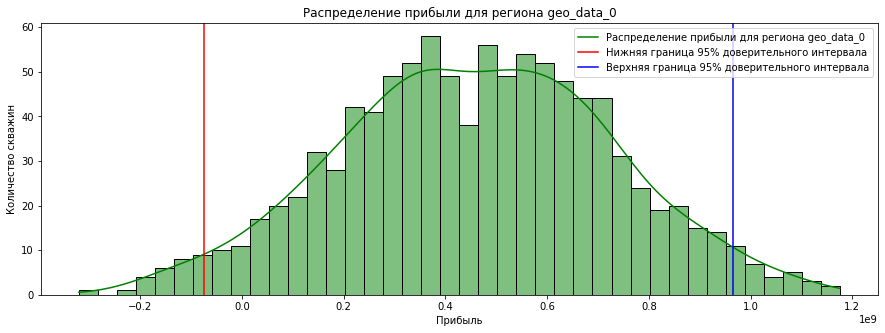

95% доверительный интервал доходности для региона geo_data_0 находится в пределах от -7.429 до 96.570 млн.рублей
Средняя прибыль для региона geo_data_0:45.868 млн.рублей
Риск убытка для региона geo_data_0:4.6%


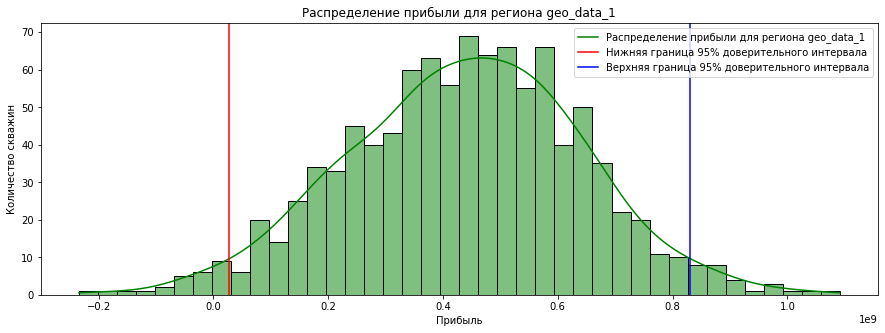

95% доверительный интервал доходности для региона geo_data_1 находится в пределах от 2.668 до 83.095 млн.рублей
Средняя прибыль для региона geo_data_1:43.770 млн.рублей
Риск убытка для региона geo_data_1:1.7%


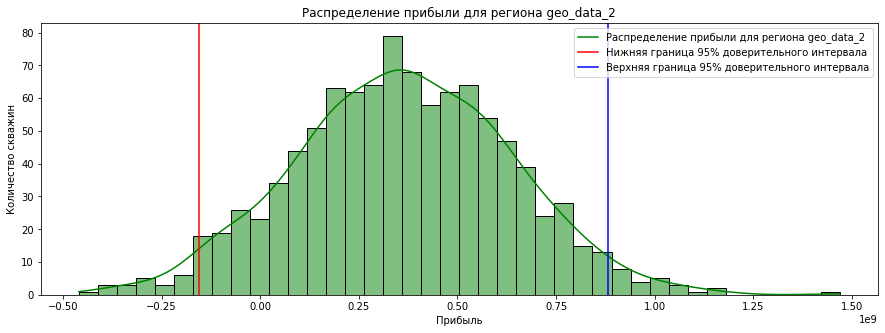

95% доверительный интервал доходности для региона geo_data_2 находится в пределах от -15.609 до 88.258 млн.рублей
Средняя прибыль для региона geo_data_2:36.218 млн.рублей
Риск убытка для региона geo_data_2:9.5%


In [27]:
data_0 = profit_and_loss(df_0['product'], df_0['predict'], 'geo_data_0')
data_1 = profit_and_loss(df_1['product'], df_1['predict'], 'geo_data_1')
data_2 = profit_and_loss(df_2['product'], df_2['predict'], 'geo_data_2')

**Вывод:** По условию после оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. В результате мы имеем высокие риски у первого и третьего регионов, риски 4,6 и 9,5 % соответственно. Регион номер два самый подходящий, риск составляет 1,7% , при этом средняя прибыль 43.770 млн.рублей на порядок выше чем у третьего 36.218 млн.рублей , и немного ниже, чем у первого регоина 45.868 млн.рублей.

# Общий вывод.

**Описание задачи:**

1. Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. 
2. Проанализировать возможную прибыль и риски техникой Bootstrap.

**Описание этапов работы:**

- Подготовка и анализ данных: была проведена оценка пропусков, дубликатов, анализ всех данных, выбросов, зависимость корреляции между признаками.
- Обучили и проверили модель для каждого региона
- Посчитали риски и прибыль для каждого региона

**Предложение для бизеса:**

Второй регион является самым привлекательным для буревой новой скажины. Вероятность убытка в данном регионе составляет 1,7%. Средняя прибыль для региона 43.770 млн.рублей.
